# Parse Microsoft Mined Road as GPKG

[Microsoft's RoadDetection Github](https://github.com/microsoft/RoadDetections) repo contain road network extracted using deep learning methods from satellite imagery. The data is a TSV format, which requires further processing. This script convert given url containing zip file from Microsoft's Github repository, subsequently convert them to Geopackage for easier processing and visualization in QGIS.

## Preparation

Setup libraries and the url. Change the url accordingly (get them from the repo: https://github.com/microsoft/RoadDetections)

In [1]:
!pip install geopandas --quiet

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 7.8 MB 49.0 MB/s 
     |████████████████████████████████| 16.6 MB 48.6 MB/s 


**Change the URL** below based on regions from the repo above.

In [2]:
# Change the URL here

url = 'https://usaminedroads.blob.core.windows.net/road-detections/SouthAmerica-Full.zip'

In [3]:
# extract filename from link above
filename = url.split('/')[4]
filename = filename.split('.')[0] + '.tsv'

print(filename)

SouthAmerica-Full.tsv


## Extract Data on Selected Country

Download file the from URL above, extract zip file, convert them to pandas dataframe

In [4]:
# Download the data
import requests
import zipfile

# Download the ZIP file
response = requests.get(url)

# Save the ZIP file to a local file
open("file.zip", "wb").write(response.content)

# Open the ZIP file
zip_ref = zipfile.ZipFile("file.zip", "r")

# Extract the contents of the ZIP file to the current directory
zip_ref.extractall()

# Close the ZIP file
zip_ref.close()

Convert the extracted TSV file to pandas Dataframe. If the dataset is too large, use Dask instead of Pandas

In [5]:
import pandas as pd

# Read the TSV file
df = pd.read_csv(filename, sep="\t", names=["country_id", "geom"], header=None)

# Print the first 5 rows of the DataFrame
print(df.head())


  country_id                                               geom
0        ARG  {"type":"Feature","geometry":{"type":"LineStri...
1        ARG  {"type":"Feature","geometry":{"type":"LineStri...
2        ARG  {"type":"Feature","geometry":{"type":"LineStri...
3        ARG  {"type":"Feature","geometry":{"type":"LineStri...
4        ARG  {"type":"Feature","geometry":{"type":"LineStri...


List all the country codes from the file. Link for reference: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

In [6]:
# list country code from the downloaded file
list_of_countries = df["country_id"].unique()
print("List of Countries: \r\n", list_of_countries)

# Number of extracted road segments per country
data_per_country = df["country_id"].value_counts()
print("\r\nData per Country:\r\n", data_per_country)

List of Countries: 
 ['ARG' 'BRA' 'FLK' 'BOL' 'GUY' 'GUF' 'PRY' 'URY' 'SGS' 'SUR' 'CHL' 'COL'
 'ECU' 'VEN' 'PER']

Data per Country:
 BRA    10154609
ARG     2843549
CHL     1037209
VEN      896277
COL      838669
PER      718768
ECU      555180
BOL      522136
PRY      409639
URY      232533
GUY       30226
SUR       24309
GUF       11368
FLK        2168
SGS          42
Name: country_id, dtype: int64


**Change the selected country** below based on the country code. 

In [7]:
# change selected country accordingly
selected_country = 'BOL'

In [8]:
# Slice the dataframe
selected_data = df.loc[df["country_id"] == selected_country, :]
print(len(selected_data))
print(selected_data.head())

522136
        country_id                                               geom
9934227        BOL  {"type":"Feature","geometry":{"type":"LineStri...
9934228        BOL  {"type":"Feature","geometry":{"type":"LineStri...
9934232        BOL  {"type":"Feature","geometry":{"type":"LineStri...
9934233        BOL  {"type":"Feature","geometry":{"type":"LineStri...
9934237        BOL  {"type":"Feature","geometry":{"type":"LineStri...


## Processing 

Extract geometry from Pandas, convert the geometry to geopandas dataframe and save the resulting GPKG

In [9]:
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape

In [10]:
# define function for parsing 

def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str)["geometry"])
    except:  # Handle NaN and empty strings
        return None

In [11]:
# Convert the column to shapely WKT geometry
# take some time to process
# %%timeit
selected_data["geometry"] = selected_data["geom"].apply(parse_geom)


<ipython-input-11-5e989cd23721>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["geometry"] = selected_data["geom"].apply(parse_geom)


In [12]:
# display the selected data
selected_data.head()

,country_id,geom,geometry
9934227,BOL,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (-68.1264352798462 -16.485812365628...
9934228,BOL,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (-62.9050540924072 -17.222565195858...
9934232,BOL,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (-68.1180238723755 -16.478435891190...
9934233,BOL,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (-68.1219720840454 -16.477726006445...
9934237,BOL,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (-65.2994620800018 -19.024613999290...


In [13]:
# make a geodataframe out of the converted geometry
gdf = gpd.GeoDataFrame(selected_data, geometry="geometry")
print(gdf.head())

        country_id                                               geom  \
9934227        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934228        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934232        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934233        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934237        BOL  {"type":"Feature","geometry":{"type":"LineStri...   

                                                  geometry  
9934227  LINESTRING (-68.12644 -16.48581, -68.12622 -16...  
9934228  LINESTRING (-62.90505 -17.22257, -62.90771 -17...  
9934232  LINESTRING (-68.11802 -16.47844, -68.11798 -16...  
9934233  LINESTRING (-68.12197 -16.47773, -68.12191 -16...  
9934237  LINESTRING (-65.29946 -19.02461, -65.29886 -19...  


(-70.26262003183363,
 -56.82592552900315,
 -23.580521787155703,
 -9.003129662237892)

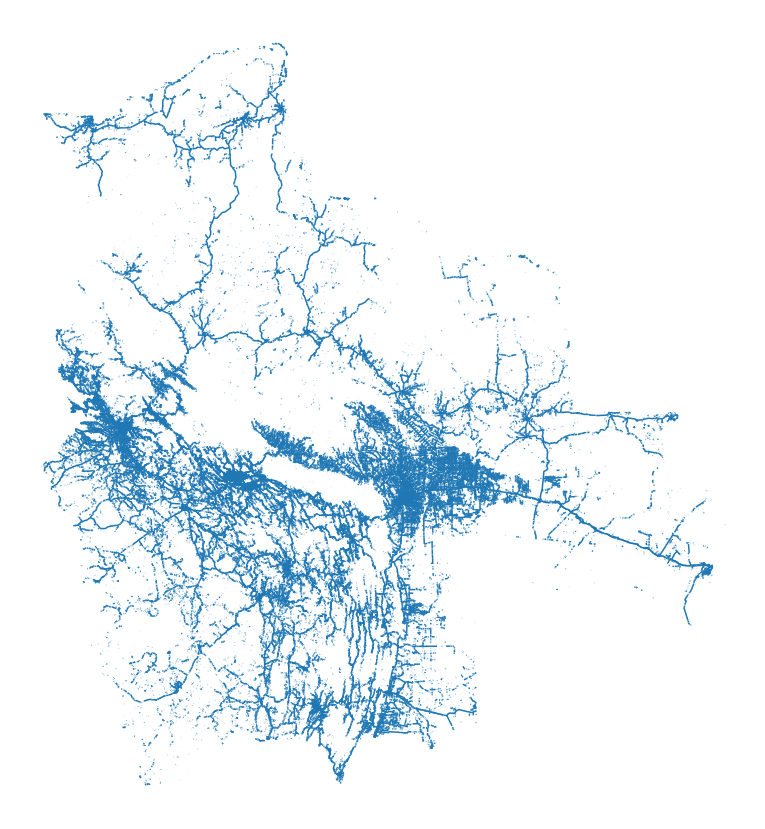

In [14]:
# Plot the data
ax = gdf.plot(figsize=(15, 15))
ax.axis('off')

Listar columnas

In [18]:
print(gdf.columns.tolist())
print(gdf.head())

['country_id', 'geom', 'geometry']
        country_id                                               geom  \
9934227        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934228        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934232        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934233        BOL  {"type":"Feature","geometry":{"type":"LineStri...   
9934237        BOL  {"type":"Feature","geometry":{"type":"LineStri...   

                                                  geometry  
9934227  LINESTRING (-68.12644 -16.48581, -68.12622 -16...  
9934228  LINESTRING (-62.90505 -17.22257, -62.90771 -17...  
9934232  LINESTRING (-68.11802 -16.47844, -68.11798 -16...  
9934233  LINESTRING (-68.12197 -16.47773, -68.12191 -16...  
9934237  LINESTRING (-65.29946 -19.02461, -65.29886 -19...  


Quitar columna 'geom'

In [19]:
gdf.drop('geom', inplace=True, axis=1)
print(gdf.head())

        country_id                                           geometry
9934227        BOL  LINESTRING (-68.12644 -16.48581, -68.12622 -16...
9934228        BOL  LINESTRING (-62.90505 -17.22257, -62.90771 -17...
9934232        BOL  LINESTRING (-68.11802 -16.47844, -68.11798 -16...
9934233        BOL  LINESTRING (-68.12197 -16.47773, -68.12191 -16...
9934237        BOL  LINESTRING (-65.29946 -19.02461, -65.29886 -19...


In [20]:
# export to gpkg
gdf.to_file(selected_country+".gpkg", driver="GPKG")

In [21]:
# download the GPKG file
from google.colab import files
files.download(selected_country+".gpkg") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>